In [ ]:
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
 #Download dataset using Kaggle CLI
!mkdir -p ~/.kaggle
!echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d omkargurav/face-mask-dataset

# Unzip
with zipfile.ZipFile("face-mask-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("face_mask_data")

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown


In [ ]:
# Prepare dataset
source_dir = '/content/face_mask_data/data'
base_dir = '/content/face_mask_data/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for category in ['with_mask', 'without_mask']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    img_dir = os.path.join(source_dir, category)
    images = os.listdir(img_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(img_dir, img), os.path.join(train_dir, category, img))
    for img in val_imgs:
        shutil.copy(os.path.join(img_dir, img), os.path.join(val_dir, category, img))


In [ ]:
# Image settings
img_size = 224
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode='binary')

val_gen = val_datagen.flow_from_directory(val_dir,
                                          target_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          class_mode='binary')

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [ ]:
# Build model using ResNet50
base_model = ResNet50(input_shape=(img_size, img_size, 3),
                      include_top=False,
                      weights='imagenet')

base_model.trainable = False  # Phase 1: freeze base

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train phase 1
model.fit(train_gen, validation_data=val_gen, epochs=5)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5244 - loss: 0.7460

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 110s 505ms/step - accuracy: 0.5245 - loss: 0.7458 - val_accuracy: 0.5963 - val_loss: 0.6656
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 121s 437ms/step - accuracy: 0.5592 - loss: 0.6868 - val_accuracy: 0.6248 - val_loss: 0.6543
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 83s 440ms/step - accuracy: 0.5661 - loss: 0.6789 - val_accuracy: 0.6115 - val_loss: 0.6540
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 430ms/step - accuracy: 0.5980 - loss: 0.6654 - val_accuracy: 0.6334 - val_loss: 0.6441
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 83s 442ms/step - accuracy: 0.6051 - loss: 0.6581 - val_accuracy: 0.6267 - val_loss: 0.6443


In [ ]:
# Phase 2: fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # freeze early layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 138s 551ms/step - accuracy: 0.7070 - loss: 0.5732 - val_accuracy: 0.7697 - val_loss: 0.4684
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 461ms/step - accuracy: 0.8500 - loss: 0.3495 - val_accuracy: 0.6671 - val_loss: 0.8963
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 463ms/step - accuracy: 0.8570 - loss: 0.3171 - val_accuracy: 0.5917 - val_loss: 1.3428
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 88s 466ms/step - accuracy: 0.9081 - loss: 0.2354 - val_accuracy: 0.8882 - val_loss: 0.2652
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 141s 460ms/step - accuracy: 0.9168 - loss: 0.2144 - val_accuracy: 0.6208 - val_loss: 1.5184
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 458ms/step - accuracy: 0.9292 - loss: 0.1800 - val_accuracy: 0.8875 - val_loss: 0.2906
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 458ms/step - accuracy: 0.9393 - loss: 0.1607 - val_accuracy: 0.9199 - val_loss: 0.2011
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 459ms/step - accuracy: 0.9326 - loss:

In [ ]:
# Evaluate
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc:.2f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8576 - loss: 0.5807
Validation Accuracy: 0.87


In [ ]:
# Test with real image
def predict_image(path):
    img = load_img(path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    label = "With Mask" if pred < 0.5 else "Without Mask"
    print(f"Prediction: {label} ({pred:.2f})")
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()

In [ ]:
from google.colab import files

# Upload an image file
uploaded = files.upload()



TypeError: 'NoneType' object is not subscriptable

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: Without Mask (0.99)


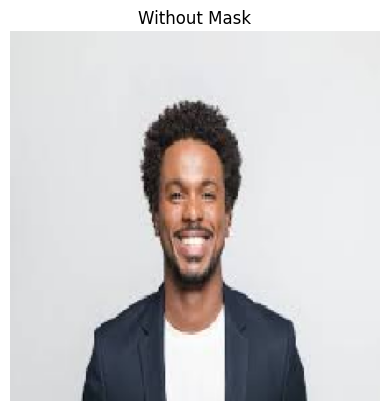

In [ ]:
# Get the filename
filename = list(uploaded.keys())[0]

# Call the prediction function
predict_image(filename)
